In [ ]:
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


In [ ]:
#unzip
#path_to_zip_file = '/content/drive/MyDrive/tensorflow-image-classification-master-2/chartimges.zip'
#directory_to_extract_to = '/content/drive/MyDrive/tensorflow-image-classification-master-2/'


#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#    zip_ref.extractall(directory_to_extract_to)

In [ ]:
#이미지 데이터 경로
train_data_dir = '/content/drive/MyDrive/tensorflow-image-classification-master-2/chartimges/'

#이미지 데이터 로더 설정
train_datagen = ImageDataGenerator(
      rescale = 1.0/255.0, #정규화
      validation_split = 0.2) #검증 데이터셋 비율

#훈련 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (224, 224), #resnet에 맞는 크기
    batch_size = 32,
    class_mode = 'categorical', #다중 클래스 분류
    subset = 'training') #훈련데이터로 사용할 데이터 선택

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print("Class indices:", class_indices)
print("Class names:", class_names)


Found 7065 images belonging to 4 classes.
Class indices: {'bar': 0, 'line': 1, 'pie': 2, 'table': 3}
Class names: ['bar', 'line', 'pie', 'table']


In [ ]:
#원본 데이터셋 디렉터리 경로
original_dataset_dir =  '/content/drive/MyDrive/tensorflow-image-classification-master-2/chartimges'

#분할된 데이터셋 저장할 디렉터리 경로
base_dir =  '/content/drive/MyDrive/tensorflow-image-classification-master-2/chartimges/split_dataset'

os.makedirs(base_dir, exist_ok=True)

#클래스별 디렉터리 생성
classes = ['bar', 'line', 'pie', 'table']
for class_name in classes:
  class_dir = os.path.join(original_dataset_dir, class_name)
  all_image_names = os.listdir(class_dir)
  train_image_names, test_image_names = train_test_split(all_image_names, test_size = 0.2, random_state=42)

  for image_name in train_image_names:
    src = os.path.join(class_dir, image_name)
    dst = os.path.join(base_dir, 'train', class_name, image_name)
    dst_path = os.path.join(base_dir, 'train', class_name)
    os.makedirs(dst_path, exist_ok=True)
    shutil.copyfile(src, dst)

  for image_name in test_image_names:
    src = os.path.join(class_dir, image_name)
    dst = os.path.join(base_dir, 'test', class_name, image_name)
    dst_path = os.path.join(base_dir, 'test', class_name)
    os.makedirs(dst_path, exist_ok=True)
    shutil.copyfile(src, dst)


In [ ]:
#이미지 데이터 경로
train_data_dir = os.path.join(base_dir, 'train')

#이미지 데이터 증강 설정
train_datagen = ImageDataGenerator(
      rescale = 1.0/255.0, #정규화
      rotation_range = 20,  #이미지 회전 각도
      width_shift_range = 0.2, #가로 방향으로 이동 범위
      height_shift_range = 0.2, #세로 방향으로 이동 범위
      horizontal_flip = True, #수평반전 적용
      validation_split = 0.2) #검증 데이터셋 비율


#훈련 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (224, 224), #resnet에 맞는 크기
    batch_size = 32,
    class_mode = 'categorical', #다중 클래스 분류
    subset = 'training') #훈련데이터로 사용할 데이터 선택

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print("Class indices:", class_indices)
print("Class names:", class_names)


Found 5652 images belonging to 4 classes.
Class indices: {'bar': 0, 'line': 1, 'pie': 2, 'table': 3}
Class names: ['bar', 'line', 'pie', 'table']


In [ ]:
#모델 불러오기
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
#모델 수정(클래스에 맞게 레이어 수정)
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))  # 클래스 수에 맞는 출력 레이어 추가

In [ ]:
#모델 컴파일 및 훈련
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# 모델 훈련
history = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping])



Found 1411 images belonging to 4 classes.
Epoch 1/50
177/177 [==============================] - 226s 970ms/step - loss: 0.2141 - accuracy: 0.9483 - val_loss: 1.3752 - val_accuracy: 0.3437
Epoch 2/50
177/177 [==============================] - 160s 906ms/step - loss: 0.0826 - accuracy: 0.9756 - val_loss: 2.6736 - val_accuracy: 0.3508
Epoch 3/50
177/177 [==============================] - 159s 900ms/step - loss: 0.0588 - accuracy: 0.9832 - val_loss: 1.5339 - val_accuracy: 0.3494
Epoch 4/50
177/177 [==============================] - 157s 889ms/step - loss: 0.1238 - accuracy: 0.9690 - val_loss: 4.8374 - val_accuracy: 0.4054
Epoch 5/50
177/177 [==============================] - 158s 891ms/step - loss: 0.0544 - accuracy: 0.9848 - val_loss: 2.8832 - val_accuracy: 0.4585
Epoch 6/50
177/177 [==============================] - 169s 953ms/step - loss: 0.0510 - accuracy: 0.9837 - val_loss: 1.7515 - val_accuracy: 0.6464


In [ ]:
#모델 평가
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # 이미지 값을 정규화
#이미지 데이터 경로
test_data_dir = os.path.join(base_dir, 'test')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # 테스트 데이터는 순서를 유지하기 위해 shuffle 비활성화
)

eval_result = model.evaluate(test_generator)
print("Test loss:", eval_result[0])
print("Test accuracy:", eval_result[1])

Found 1765 images belonging to 4 classes.
56/56 [==============================] - 15s 266ms/step - loss: 1.3727 - accuracy: 0.3433
Test loss: 1.3726674318313599
Test accuracy: 0.34334278106689453


In [ ]:
model.save('image_classify.h5')

In [ ]:
def model_test(file_path):
  # 모델 로드
  model = tf.keras.models.load_model('/content/image_classify.h5')

  # 이미지 불러오기
  image_path = file_path
  image = Image.open(image_path)
  image = image.resize((224, 224))  # 모델의 입력 크기에 맞게 조정
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  image_array = tf.expand_dims(image_array, axis=0)  # 배치 차원 추가
  image_array = image_array[:, :, :, :3]  # 채널 수 조정


  # 이미지 전처리 (예: 정규화)
  image_array = tf.keras.applications.mobilenet_v2.preprocess_input(image_array)

  # 모델 예측
  predictions = model.predict(image_array)
  predicted_class = tf.argmax(predictions, axis=1)[0]
  class_labels = ['bar', 'line', 'pie', 'table']  # 클래스 레이블 리스트

  print("Predicted class:", class_labels[predicted_class])
  print("Class probabilities:", predictions)
  return

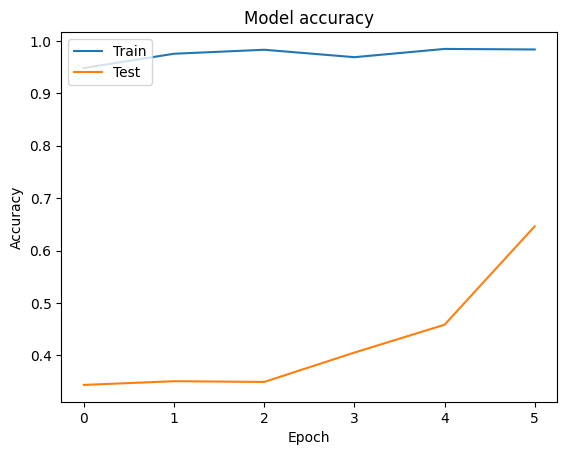

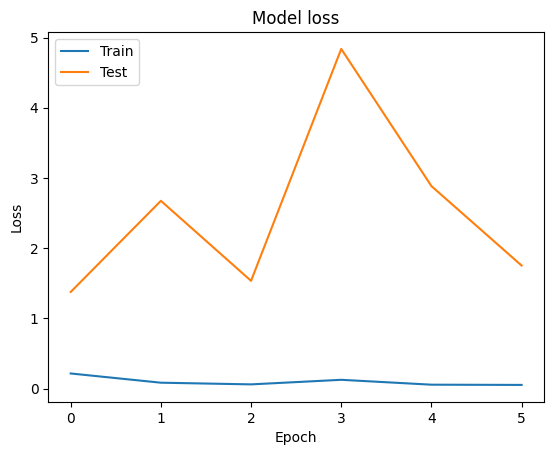

In [ ]:
#훈련 과정 시각화(정확도)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#훈련 과정 시각화(손실)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#유형별 이미지 테스트

#클래스별 디렉터리 생성
classes = ['bar', 'line', 'pie', 'table']
for class_name in classes:
  class_dir = os.path.join(base_dir, 'test',class_name)
  all_image_names = os.listdir(class_dir)
  test_images = all_image_names[:10]
  for image_file in test_images:
    file_path = os.path.join(class_dir, image_file)
    model_test(file_path)
    print(class_name)

1/1 [==============================] - 1s 1s/step
Predicted class: line
Class probabilities: [[0.29566333 0.30119333 0.20702752 0.19611584]]
bar
1/1 [==============================] - 1s 841ms/step
Predicted class: line
Class probabilities: [[0.29213655 0.29573703 0.2111722  0.20095427]]
bar
1/1 [==============================] - 1s 1s/step
Predicted class: bar
Class probabilities: [[0.29500523 0.28957656 0.21567136 0.19974683]]
bar
1/1 [==============================] - 1s 859ms/step
Predicted class: bar
Class probabilities: [[0.30760473 0.3060202  0.2025916  0.18378349]]
bar


1/1 [==============================] - 1s 867ms/step
Predicted class: bar
Class probabilities: [[0.29627496 0.29454908 0.21190535 0.19727059]]
bar


1/1 [==============================] - 1s 905ms/step
Predicted class: bar
Class probabilities: [[0.30019566 0.2982959  0.20896746 0.19254097]]
bar
1/1 [==============================] - 1s 907ms/step
Predicted class: bar
Class probabilities: [[0.29227674 0.28343576 0.22065142 0.20363608]]
bar
1/1 [==============================] - 1s 878ms/step
Predicted class: bar
Class probabilities: [[0.30633357 0.30460212 0.20409304 0.1849713 ]]
bar
1/1 [==============================] - 1s 880ms/step
Predicted class: bar
Class probabilities: [[0.29548696 0.29500282 0.21161439 0.19789582]]
bar
1/1 [==============================] - 1s 1s/step
Predicted class: bar
Class probabilities: [[0.29705653 0.29170576 0.21398783 0.19724987]]
bar
1/1 [==============================] - 1s 890ms/step
Predicted class: bar
Class probabilities: [[0.2848116  0.2775995  0.22512358 0.2124653 ]]
line
1/1 [==============================] - 1s 864ms/step
Predicted class: bar
Class probabilities: [[0.29054403 0.28143364 0

In [ ]:
import shutil
from google.colab import files

shutil.make_archive('split_dataset', 'zip', '/content/drive/MyDrive/tensorflow-image-classification-master-2/chartimges/split_dataset')
files.download('<압축_파일_이름>.zip')

FileNotFoundError: ignored

In [ ]:
#유형별 이미지 수 확인
#원본 데이터셋 디렉터리 경로
original_dataset_dir =  '/content/drive/MyDrive/tensorflow-image-classification-master-2/chartimges'

#분할된 데이터셋 저장할 디렉터리 경로
base_dir =  '/content/drive/MyDrive/tensorflow-image-classification-master-2/chartimges/split_dataset'

#클래스별 디렉터리 생성
classes = ['bar', 'line', 'pie', 'table']
for class_name in classes:
  class_dir1 = os.path.join(base_dir, 'train',class_name)
  all_image_names1 = os.listdir(class_dir1)
  print(f'{class_name}:{len(all_image_names1)}')

  class_dir2 = os.path.join(base_dir, 'test',class_name)
  all_image_names2 = os.listdir(class_dir2)
  print(f'{class_name}:{len(all_image_names2)}')


bar:2478
bar:620
line:1543
line:386
pie:1108
pie:277
table:1936
table:484
